<center><h1><font color='red'> Guide 4 |  Signal Processing </font></h1></center>

<h2>Summary</h2>
<p>Behavior is not an instantaneous action, but rather a continuous stream of movement. Therefore, you will have to use signal processing to analyze temporal data and inspect any patterns within the signal. Note that the field of signal processing is vast and impossible to cover through this one notebook alone. However, we will go over some basic tools that are availabe and allow you to explore others on your own. First, you will learn the fundamentals of filtering low or high frequency noises using low-pass, high-pass, and band-pass filter. Then you will learn how to understand your signal by using Fast Fourier Transformation (FFT), which converts your orignal data from the time domain to the frequency domain. Finally, you will learn how to use Wavelet Transformation to analyze your data in the time-frequency domain and see differences in using this method over FFT.</p>

Here is an interesting video to convice you why signal processing is very important: [Here](https://www.youtube.com/watch?v=mexN6d8QF9o)

## Objectives
* DeepLabCut/SLEAP Output Data Format
* Low, High, and Band- Pass Filtering
* Fast-Fourier Transformation (FFT)
* Wavelet Transformation
* Difference between FFT and Wavelet Transformation

## Table of Content:
0. Signals
1. Filtering
2. FFT
3. Wavelet Transformation
4. Applications

In [1]:
# Center Figures
from IPython.core.display import HTML
HTML("""<style>.output_png {display: table-cell;text-align: center;vertical-align: middle;}</style>""")

## 0. Signals
By [Wikipedia's](https://en.wikipedia.org/wiki/Signal) definition: "a signal is a function that conveys information about a phenomenon. In electronics and telecommunications, it refers to any time varying voltage, current or electromagnetic wave that carries information."

In our case, we will use the change in body position across time as our signal. However, DeepLabCut may fail to accurately label all the body points, introducing noises and errors. Ideally, we would like to eliminate all of these before further analysis. Below I will show you some tools to filter and analyze signals in the time-frequency domain so that you will be better equipped to analyze DeepLabCut signals.

In the data folder, I have provided you an artificial, noisy signal (frames per second (fps) is 200). If you look at the figure below, you can see that this signal is 2400 frames (12 sec) long.

<i>- If you want to see how I created this dummy data, scroll all the way to the bottom. You can also modify/rerun that code at the bottom to create your own dummy data, and test the limits of various filtering tools -</i>

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


number of frames: 2400 frames
time: 12.0 s


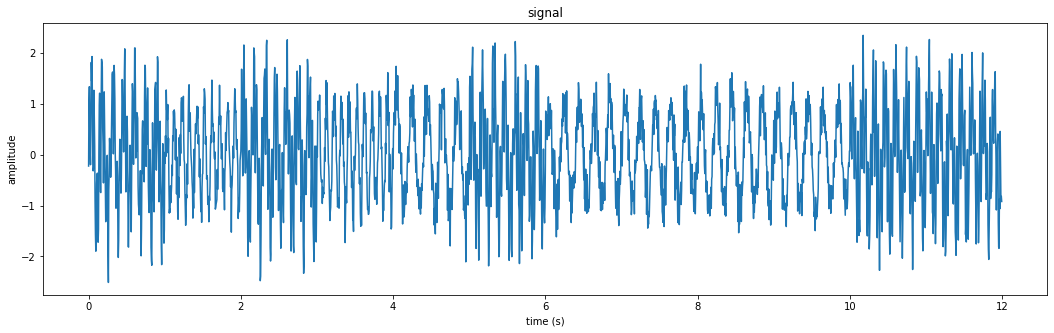

In [4]:
dummy_signal = np.load("data/dummy_data.npy")
fps = 200

num_frame = dummy_signal.shape[0]
dummy_time = np.arange(num_frame)/fps
print(f"number of frames: {num_frame} frames")
print(f"time: {num_frame/fps} s")

fig = plt.figure(figsize=(18, 5))
plt.plot(dummy_time, dummy_signal)
plt.title("signal"); plt.xlabel("time (s)"); plt.ylabel("amplitude");
plt.show()

As you can see from this signal, there seems to be some pattern if you look REALLY hard. However, it is hard to say what it is and when this pattern starts and stops. Part of data pre-processing is understanding your data. If you zoom into the first 300 frames (1.5 sec), you can see slightly more sinusoidal pattern. However, the pattern does not seem to be as consistent, which makes sense since I have introduced some random Gaussian noise into the signal. Therefore, the next logical step is filtering these noises out!

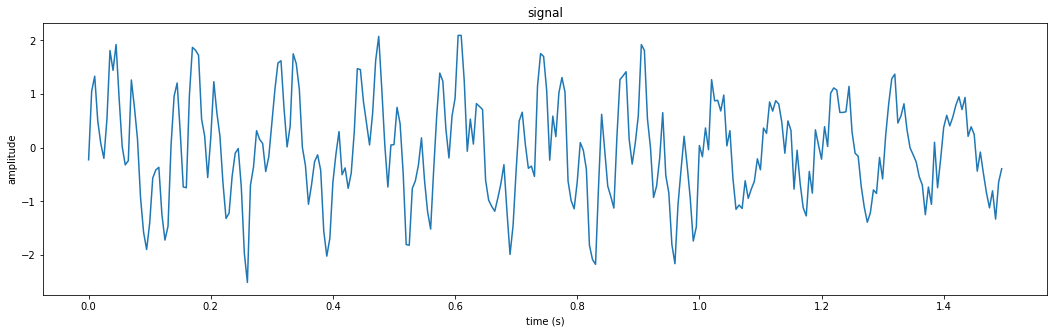

In [5]:
fig=plt.figure(figsize=(18, 5))
plt.plot(dummy_time[:300], dummy_signal[:300])
plt.title("signal")
plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.show()

## 1. Filtering (High/Low/Band Pass Filter)

<p>There are many ways to remove noises. I recommend you start by changing your experimental settings to minimize the amount of error introduced into your recording in the first place. As a rule of thumb, the closer to the source of data you fix the problem, the less error you introduce downstream. For example, if you are recording a video of an animal and are tracking some body points, you want to make sure there is enough lighting so that there is sufficient contrast between the animal and the background. This way, DeepLabCut will not mistakingly label body markers and introduce unnecessary errors. Another simple example is recording your own voice. If you are out in the street trying to audio record your speech, you are going to get unwanted noise from other pedestrians or even background noise from the wind or other environmental factors. Therefore, to remove noise, the best thing you want to do is go into a quiet room so that the recording only picks up your voice and nothing else.</p>

Now, once you have removed unwanted signals via your experimental settings to the best of your ability, you will find that, more often than not, you will still have some errors. These noise may result from the prediction made by DeepLabCut or the electrical circuit of your recording device. The source of noises are vast and vary depending on your experimental setup. There are many forms of noises that may be too hard for you to account for via your experimental setup. In this case, you want to programatically remove unwanted background noise using various [filtering methods](https://docs.scipy.org/doc/scipy/reference/signal.html#filtering). Rather than going through every filtering tool, we will specifically go over high/low/band pass filter.

<p>Before we start, you may be wondering, what is this low and high frequency noise that I keep talking about and what does that have to do with high/low/band pass filter? Well, I am glad you asked! Below I create some plots to explain this concept.</p>


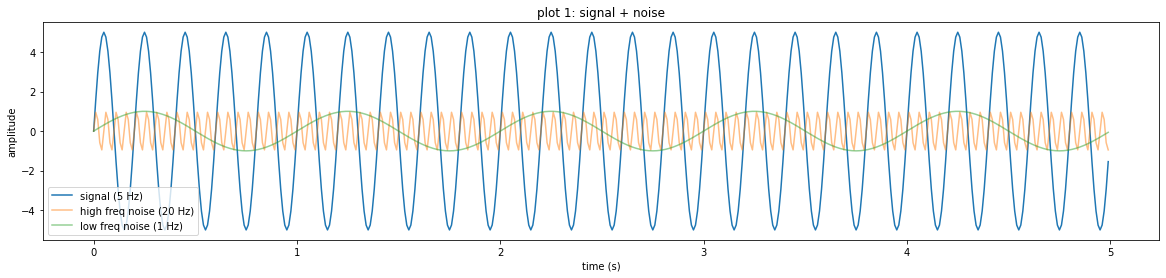

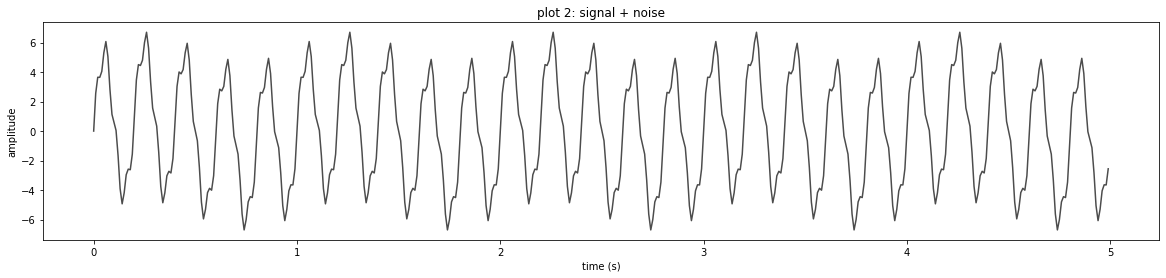

In [6]:
# background info
fps = 100                                           # unit: frames/sec
number_sec = 5
time = np.arange(0,number_sec,1/fps)

# signal
signal_f, signal_amp = 5,5                          # unit: Hz, amplitude
signal = signal_amp * np.sin(2*np.pi*signal_f*time) # sin(2*pi*f*t)

# noise
high_freq_noise = 20                                # unit: Hz
high_noise = np.sin(2*np.pi*high_freq_noise*time)
low_freq_noise = 1                                  # unit: Hz
low_noise = np.sin(2*np.pi*low_freq_noise*time)

# signal + noise separate figure
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(time, signal, label=f"signal ({signal_f} Hz)")
ax.plot(time, high_noise, alpha=0.5, label=f"high freq noise ({high_freq_noise} Hz)")
ax.plot(time, low_noise, alpha=0.5, label=f"low freq noise ({low_freq_noise} Hz)")
ax.set_xlabel("time (s)"), ax.set_ylabel("amplitude"), ax.set_title("plot 1: signal + noise")
plt.legend()
plt.show()

# signal + noise combined figure
noisy_signal = signal+high_noise+low_noise
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(time, noisy_signal, 'k', alpha=0.7)
ax.set_xlabel("time (s)"), ax.set_ylabel("amplitude"), ax.set_title("plot 2: signal + noise")
plt.show()

**Noise**

As you can see from plot 1, I introduced a sinusoidal signal along with two different noises. 
    
* One noise has high frequency (orange). This type of noise oscillates quickly (hence high freq), and common sources of these errors are radio frequency, lightings, mispredicition made by DeepLabCut, etc. 
* The other type of noise is low frequency (green). This type of noise oscillates slowly (hence low freq), and common sources are background noise from urban environment, unwanted displacements, etc.
    
Our signal has a frequency that lies right in the middle of these two noises. From plot 2, you can see the combination of our signal and noises. This is typically what you will see when you record your signal. Now, it is your job to be able to convert this back to the blue, clean signal you see in plot 1. How do you do this?
    
**Filtering**

Well, one way is to use high/low/band pass filtering. Although explaining the math behind it may be hard (we highly encourage you to look it up if you have time), this filtering method is conceptually very easy. 
    
* High-pass Filter lets you only "pass" frequency signal "higher" than a certain threshold. Thus you must give this filtering a lower limit threshold.   
* Low-pass Filter lets you only "pass" frequency signal "lower" than a certain threshold. Thus you must give this filtering a higher limit threshold. 
* Band-pass Filter lets you only "pass" frequency signal "between" certain thresholds. Thus you must give this filtering a lower and higher limit thresholds.

Below we will use ["Butterworth Filter"](https://scipy-cookbook.readthedocs.io/items/ButterworthBandpass.html) - a specific tool for high/low/bandpass filter - to filter out unnecssary noises. Since we have low and high noises, we will use bandpass filter. 

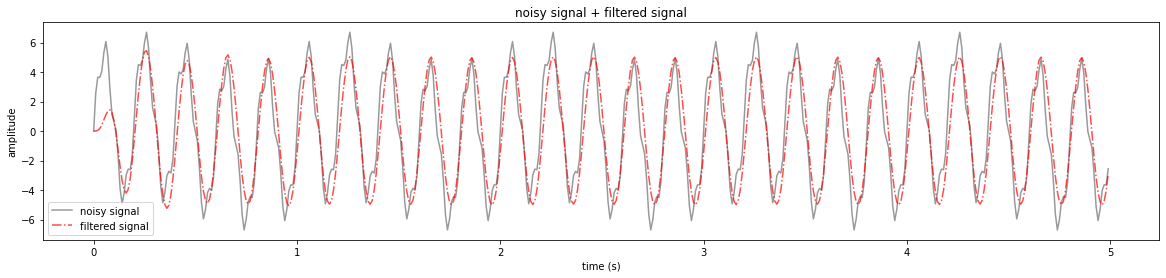

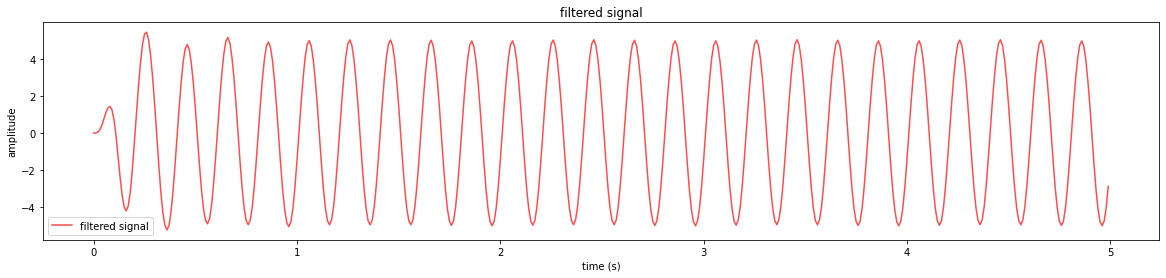

In [7]:
from scipy.signal import butter, lfilter

# parameters
lowcut = 2 # lower frequency threshold; unit: Hz
highcut = 10  # upper frequency threshold; unit: Hz
order = 4     # what is this for? look at doc

# computations
nyq = 0.5 * fps
low = lowcut / nyq
high = highcut / nyq

# filtering
b, a = butter(order, [low, high], btype='band')
filtered_signal = lfilter(b, a, noisy_signal)

# plot
fig, ax = plt.subplots(figsize=(20,4))
ax.plot(time, noisy_signal, 'k', alpha=0.4, label="noisy signal")
ax.plot(time, filtered_signal, 'r-.', alpha=0.7, label="filtered signal")
ax.set_xlabel("time (s)"), ax.set_ylabel("amplitude"), ax.set_title("noisy signal + filtered signal")
plt.legend()
plt.show()

fig, ax = plt.subplots(figsize=(20,4))
ax.plot(time, filtered_signal, 'r-', alpha=0.7, label="filtered signal")
ax.set_xlabel("time (s)"), ax.set_ylabel("amplitude"), ax.set_title("filtered signal")
plt.legend()
plt.show()

Looks pretty good! As you can see from the second figure, most of the low and high frequency noises are now gone. Now, let's apply this butterworth bandpass filter to our original dummy data!

In [8]:
from scipy.signal import butter, lfilter

# parameters
fps = 200
lowcut = 0.01
highcut = 35
order = 5

# computations
nyq = 0.5 * fps
low = lowcut / nyq
high = highcut / nyq

# filtering
b, a = butter(order, [low, high], btype='band')
signal_filt = lfilter(b, a, dummy_signal)

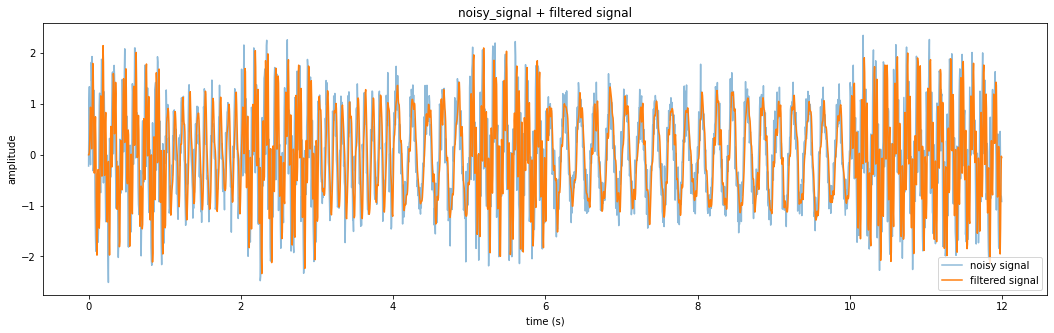

In [9]:
fig=plt.figure(figsize=(18, 5))
plt.plot(dummy_time, dummy_signal, alpha=0.5, label="noisy signal")
plt.plot(dummy_time, signal_filt, label="filtered signal")
plt.title("noisy_signal + filtered signal"); plt.xlabel("time (s)"); plt.ylabel("amplitude")
plt.legend()
plt.show()

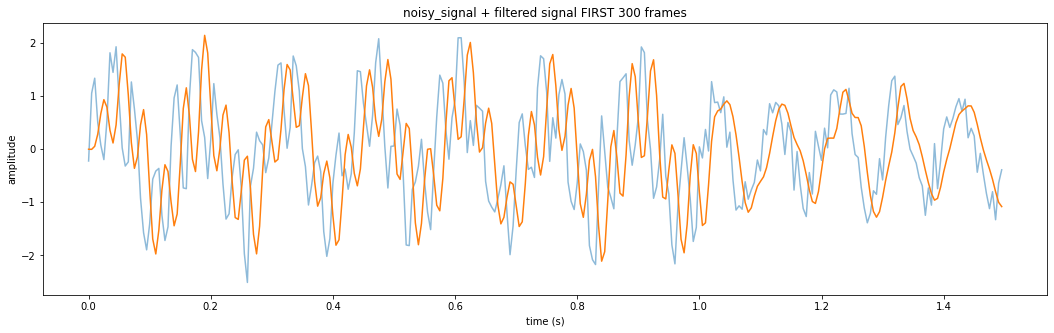

In [10]:
fr_min, fr_max = 0, 300
fig=plt.figure(figsize=(18, 5))
plt.plot(dummy_time[fr_min:fr_max], dummy_signal[fr_min:fr_max], alpha=0.5, label="noisy signal")
plt.plot(dummy_time[fr_min:fr_max], signal_filt[fr_min:fr_max], label="filtered signal")
plt.title("noisy_signal + filtered signal FIRST 300 frames"); plt.xlabel("time (s)"); plt.ylabel("amplitude")
plt.show()

## 2. Fourier Transformation

As you can see from filtering, you can easily be overwhelmed with the complexity of even one signal. Imagine how much harder it would be to analyze multiple signals with many sources of noise. 

One way to better understand your signal is to perform fast fourier transform (FFT). This also requires a lot of math, which I will not go over here. However, I recommend you search online to learn more because it will definitely serve you well throughout your research career if you do any temporal/computational analysis. Check this [youtube video](https://www.youtube.com/watch?v=spUNpyF58BY) (HIGHLY RECOMMEND) as a start!

Long story short, FFT allows you to analyze your signal and compute a "power-frequency plot" that informs you what sort of frequency signals exist in your data. Still confusing? Let me explain using some code and plot I created below.

For analysis, we will use [Scipy FFT](https://docs.scipy.org/doc/scipy/reference/fft.html#module-scipy.fft)

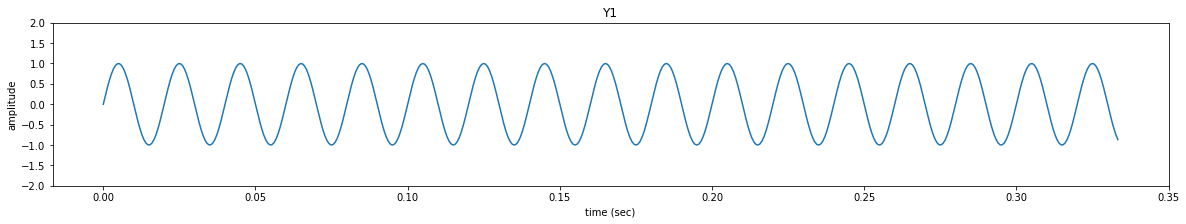

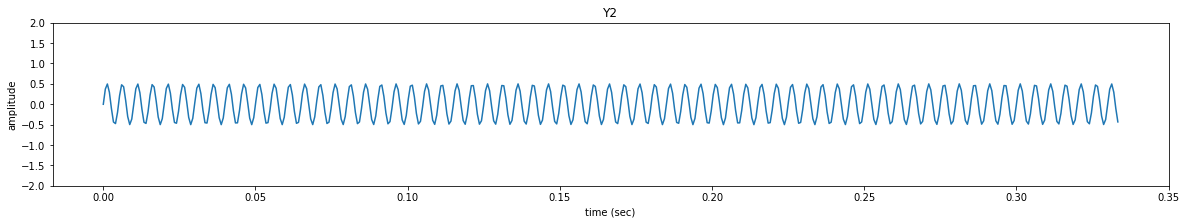

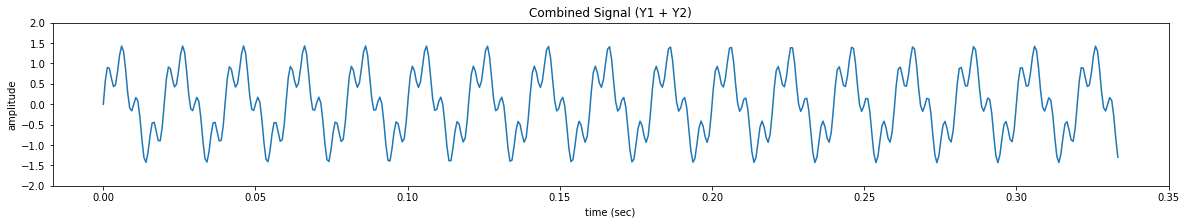

In [11]:
import scipy.fft

# General
N = 500       # unit: frames
fps = 1500    # unit: frames/sec
dt = 1 / fps  # unit: sec
x = np.linspace(0.0, N*dt, N)


# Sinusoidal graph 1
f1 = 50       # unit: Hz
y1 = np.sin(f1 * 2.0*np.pi*x) 
# plot
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(x, y1)
plt.xlabel("time (sec)"); plt.ylabel("amplitude"); plt.title("Y1"); plt.ylim(-2,2)
plt.show()

# Sinusoidal graph 2
f2 = 200      # unit: Hz
y2 = 0.5*np.sin(f2 * 2.0*np.pi*x)
# plot
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(x, y2)
plt.xlabel("time (sec)"); plt.ylabel("amplitude"); plt.title("Y2"); plt.ylim(-2,2)
plt.show()

# combined plot
combined_signal = y1+y2
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(x, combined_signal)
plt.xlabel("time (sec)"); plt.ylabel("amplitude"); plt.title("Combined Signal (Y1 + Y2)"); plt.ylim(-2,2)
plt.show()

Above is an example signal I just created for this demonstration. We have 1 signal made up of a combination of two sinusoidal graph, each with their own frequency (f1 and f2). The goal of FFT is to use this 1 signal and predict the frequencies that make up the data.

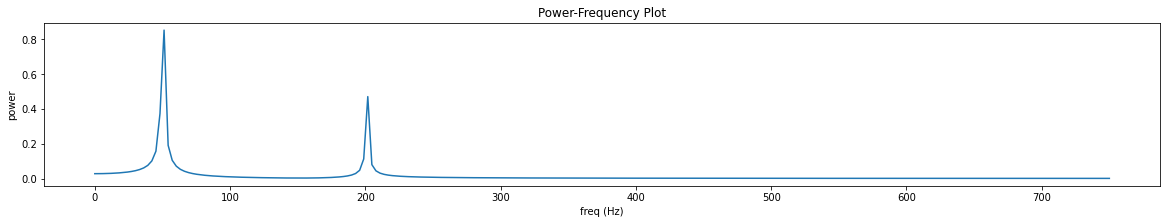

In [12]:
# Fast-Fourier Transformation: FFT
yf = scipy.fft.fft(combined_signal)
xf = np.linspace(0.0, 1.0/(2.0*dt), int(N/2))

# Plot 2
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(xf, 2.0/N * np.abs(yf[:(N//2)]))     # first half of yf is pos freq, second half is neg freq
plt.xlabel("freq (Hz)"); plt.ylabel("power"), plt.title("Power-Frequency Plot")
plt.show()

The output of FFT should be this Power-frequency plot. The power informs us the strength of a given frequency in a signal. For example, here you can see two peaks, one around 50 HZ and the other around 200 Hz. Therefore, the signal is a combination of two sinusoidal waves with 50 and 200 Hz, which is what we expected based on how we generated our data. Also note that the power of the peaks are also different. The power for 50Hz is twice as high as 200Hz. This is because, if you look at how we generated our sinusoidal data, the amplitude for y1 (i.e. the sinusoidal graph for 50Hz) is twice as large as y2 (100Hz).

Now lets introduce some random noise to see how the power-frequency graph will differ. Try changing the mean and std to change the property of the noise. If you increase std, the amplitude of the noise will increase. If you change the mean, the entire signal will be displaced by the mean.

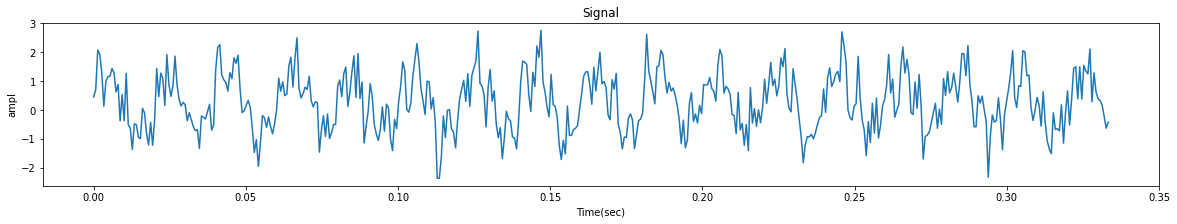

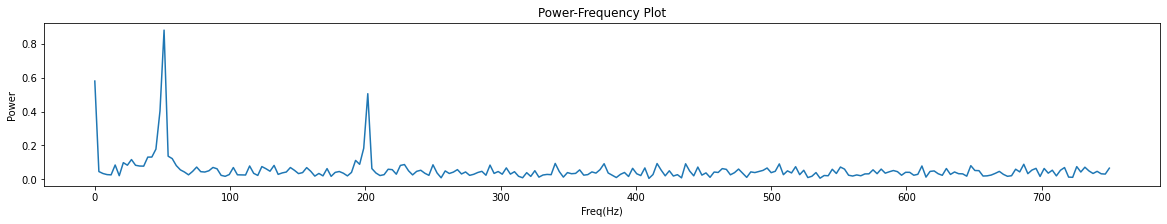

In [13]:
# Number of sample points
N = 500       # unit: frames
f1 = 50       # unit: Hz
f2 = 200      # unit: Hz
fps = 1500     # unit: frames/sec
dt = 1 / fps  # unit: sec

# Random Gaussian Noise
mean = 0.3
std = 0.5

# Generate signal
x = np.linspace(0.0, N*dt, N)
y = np.sin(f1 * 2.0*np.pi*x) + 0.5*np.sin(f2 * 2.0*np.pi*x)+np.random.normal(loc=mean, scale=std, size=(N))

fig, ax = plt.subplots(figsize=(20,3))
ax.plot(x, y)
plt.xlabel("Time(sec)"); plt.ylabel("ampl"), plt.title("Signal")
plt.show()

# FFT
yf = scipy.fft.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*dt), int(N/2))

fig, ax = plt.subplots(figsize=(20,3))
ax.plot(xf, 2.0/N * np.abs(yf[:(N//2)]))     # first half of yf is pos freq, second half is neg freq
plt.xlabel("Freq(Hz)"); plt.ylabel("Power"), plt.title("Power-Frequency Plot")
plt.show()

If you look at our noisy signal, you can barely make out any patterns. You can barely even tell if the signal is sinusoidal. However, if you use FFT and observe the power-frequency plot, you can see that there are still two peaks: one at 50Hz and 200Hz. However, there curve is no longer smooth because of the random Gaussian noises we introduced. Now you may be asking, what is that large peak at the very beginning. If you watch the youtube video I recommended from above, you should understand why we have it. Long story short, the peak at 0 Hz informs us the offset of the entire signal. Since we intrduced a gaussian signal with a specific mean value, the entire signal is offset by a certain value. This offset is like a "sinusoidal" signal that oscillates at (0Hz; or you can call it no oscillation at all).

## 3. Wavelet Transformation

FFT is amazing in all, but the one downside is that the frequency of the signal must be the same throughout the entire data (throughout the entire time). However, this is usually not the case in real life. For example, if a person is running, he may be running a certain pace, but eventually one will slow down or even speed up. Signals are usually constantly changing for any forms of behavior, making FFT less useful. Luckily there is something called the Wavelet Transformation. This is like FFT, except now you are working with one extra dimension (time). Rather than justing having power and frequency, you now have power, frequency, and time. Therefore, we can analyze the frequencies of a signal at a given time. This means that the signal does not have to be oscillating with a similar pattern throughout the entire duration of the data.

Check this guide below to gain a better grasp of Wavelet Transformation:
Wiki Guide: [Here](https://en.wikipedia.org/wiki/Continuous_wavelet_transform)

<p><a href="https://commons.wikimedia.org/wiki/File:Continuous_wavelet_transform.gif#/media/File:Continuous_wavelet_transform.gif"><img src="https://upload.wikimedia.org/wikipedia/commons/9/95/Continuous_wavelet_transform.gif" alt="Continuous wavelet transform.gif">
</a><br>

Above is a demonstartion of how wavelet transformation works. There are many forms of wavelet transformations, such as Morlet, Mexican Hat, Haar, and more. The only thing that varies between these different transformations are their filters. If you look at the animation above, you will notice how one is essentially just sliding one type of filter across time (red line). The filter used in this example is called the Morlet filter, which we will be using in this course. You can learn more about the other filters [here](https://www.eecis.udel.edu/~amer/CISC651/IEEEwavelet.pdf). To conduct morlet wavelet trasformation, we will use scipy!

* Scipy morlet2: [Here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.morlet2.html#scipy.signal.morlet2)
  * M: int (Length of the wavelet.)
  * s: float (Width parameter of the wavelet.)
  * w: float, optional (Omega0. Default is 5)
* Scipy cwt: [Here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.cwt.html#scipy.signal.cwt)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


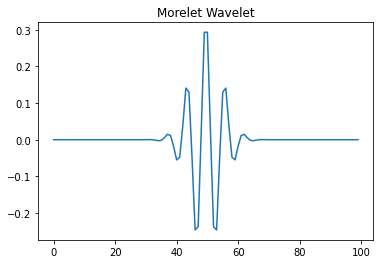

In [14]:
from scipy.signal import morlet2, cwt

M = 100; s = 5; w = 5
wavelet = morlet2(M, s, w)
plt.plot(wavelet)
plt.title("Morelet Wavelet")
plt.show()

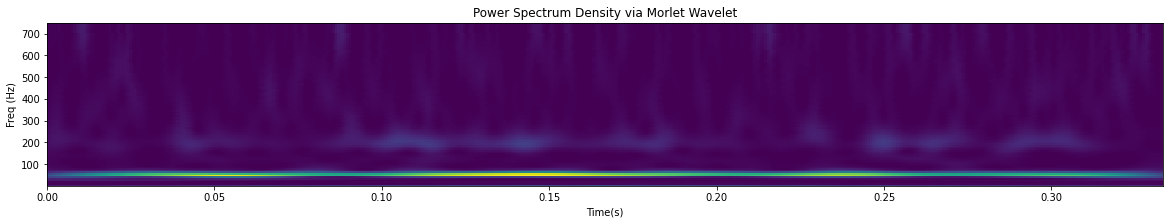

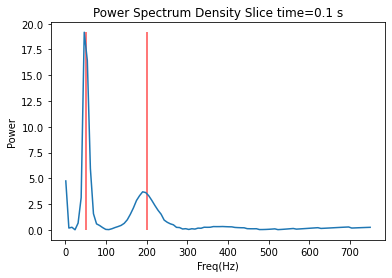

In [15]:
# morlet parameters
w = 5
freq = np.linspace(1, fps/2, 100)
widths = w*fps / (2*freq*np.pi)
# wavelet trasformation
cwtm = cwt(y, morlet2, widths, dtype=None, w=w)
power = np.abs(cwtm)**2

# plot
fig, ax = plt.subplots(figsize=(20,3))
T, S = np.meshgrid(x, widths)
ax.pcolormesh(x, freq, power, cmap='viridis')
plt.xlabel("Time(s)"); plt.ylabel("Freq (Hz)"), plt.title("Power Spectrum Density via Morlet Wavelet")
plt.show()

time = 0.1
frame = round(time*fps)
plt.plot(freq, power[:,frame])
plt.vlines(x=[f1, f2], ymin=0, ymax=power[:,frame].max(), color='r', alpha=0.7)
plt.xlabel("Freq(Hz)"); plt.ylabel("Power"), plt.title(f"Power Spectrum Density Slice time={time} s")
plt.show()

If you look at the power-frequency graph for a given time slice, you should still see two peaks, one at 50Hz and ther other at 200Hz. Hopefully this process helped you understand the similarities, pros, and cons between FFT and Wavelet Transformation.

## 4. Application
Let's now try applying Wavelet transformation on our original dummy data!

number of frames: 2400
time: 12.0s


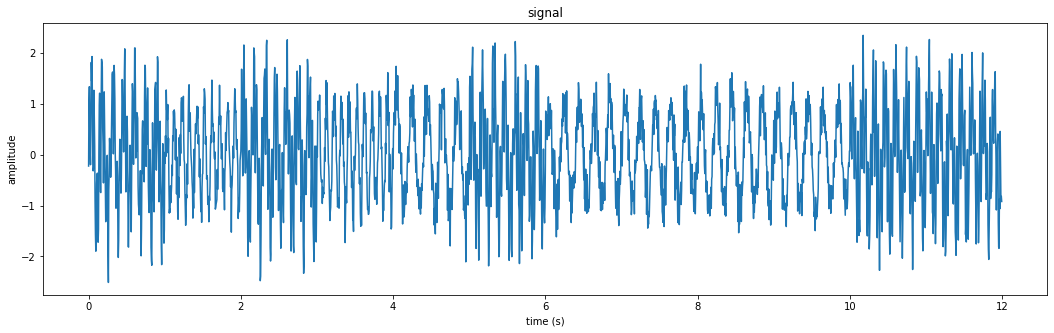

In [16]:
y = np.load("data/dummy_data.npy")
fps = 200

N = y.shape[0]
x = np.arange(N)/fps
print(f"number of frames: {N}")
print(f"time: {N/fps}s")

fig=plt.figure(figsize=(18, 5))
plt.plot(x, y)
plt.title("signal")
plt.xlabel("time (s)")
plt.ylabel("amplitude")
plt.show()

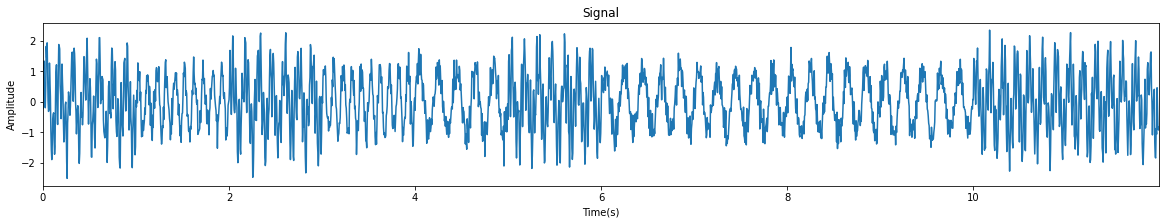

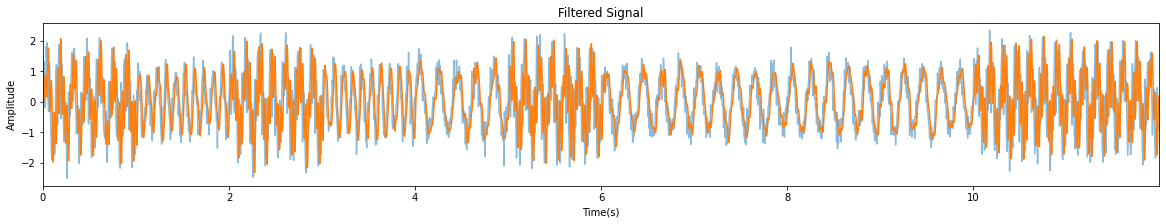

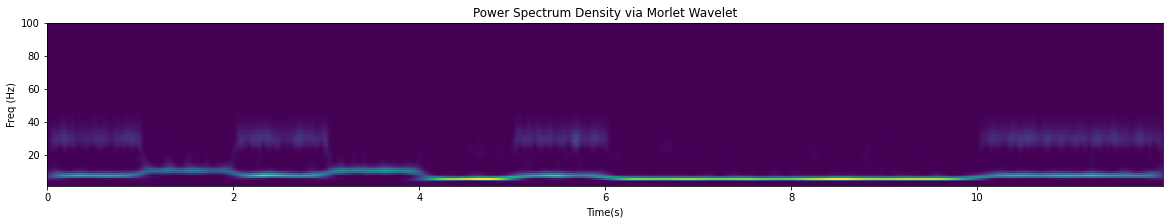

In [23]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(x, y)
ax.set_xlim([0, x.max()])
plt.xlabel("Time(s)"); plt.ylabel("Amplitude"), plt.title("Signal")
plt.show()

y_filt = None

# implement band-pass filter
if True:
    lowcut = 0.01
    highcut = 34
    order = 5

    nyq = 0.5 * fps
    low = lowcut / nyq
    high = highcut / nyq

    b, a = butter(order, [low, high], btype='band')
    y_filt = lfilter(b, a, y)
    
    fig, ax = plt.subplots(figsize=(20,3))
    
    ax.plot(x, y, alpha=0.5)
    ax.plot(x, y_filt)
    ax.set_xlim([0, x.max()])
    plt.xlabel("Time(s)"); plt.ylabel("Amplitude"), plt.title("Filtered Signal")
    plt.show()

# mortlet parameters
w = 5
freq = np.linspace(1, fps/2, 100)
widths = w*fps / (2*freq*np.pi)

# implement wavelet transform
if y_filt is not None:
    cwtm = cwt(y_filt, morlet2, widths, dtype=None, w=w)
else:
    cwtm = cwt(y, morlet2, widths, dtype=None, w=w)
power = np.abs(cwtm)**2
 
fig, ax = plt.subplots(figsize=(20,3))
ax.pcolormesh(x, freq, power, cmap='viridis')
plt.xlabel("Time(s)"); plt.ylabel("Freq (Hz)"), plt.title("Power Spectrum Density via Morlet Wavelet")
plt.show()

* Now do you see any patterns in our signal? 
* What does our Power specrogram say about our data? 
* What frequencies exist at each time range?

## CREATING DUMMY DATA

In [ ]:
# HOW I CREATED THE ARTIFICIAL DATA## 0. Signals
N = 2400
fr=200 # frame rate
X = np.zeros(N)
X_label = np.zeros(N)
time = np.arange(0,N)/fr
# frequency (Hz)
a = 30
b = 7
c = 10
d = 5

# noise
mean= 0
std = 0.3

X[0:200] = np.sin(2*np.pi*a*time[0:200])+ \
    np.sin(2*np.pi*b*time[0:200])+ \
    np.random.normal(loc=mean, scale=std, size=(200))
X_label[0:200]  = 0

X[200:400] = np.sin(2*np.pi*c*time[0:200])+ \
    np.random.normal(loc=mean, scale=std, size=(200))
X_label[200:400]  = 1

X[400:600] = np.sin(2*np.pi*a*time[0:200])+\
    np.sin(2*np.pi*b*time[0:200])+\
    np.random.normal(loc=mean, scale=std, size=(200))
X_label[400:600]  = 0

X[600:800] = np.sin(2*np.pi*c*time[0:200])+\
    np.random.normal(loc=mean, scale=std, size=(200))
X_label[600:800]  = 1

X[800:1000] = np.sin(2*np.pi*d*time[0:200])+\
    np.random.normal(loc=mean, scale=std, size=(200))
X_label[800:1000]  = 2

X[1000:1200] = np.sin(2*np.pi*a*time[0:200])+\
    np.sin(2*np.pi*b*time[0:200])+\
    np.random.normal(loc=mean, scale=std, size=(200))
X_label[1000:1200]  = 0

X[1200:2000] = np.sin(2*np.pi*d*time[0:800])+\
    np.random.normal(loc=mean, scale=std, size=(800))
X_label[1200:2000]  = 2

X[2000:2400] = np.sin(2*np.pi*a*time[0:400])+ \
    np.sin(2*np.pi*b*time[0:400])+ \
    np.random.normal(loc=mean, scale=std, size=(400))
X_label[2000:2400]  = 0

# plot
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(time[:], X[:])
plt.xlabel("second")
plt.ylabel("position")
plt.title("Example data w/ gaussian noise (m={}, s={})".format(mean, std))
plt.show()

np.save("data/dummy_data.npy", X)

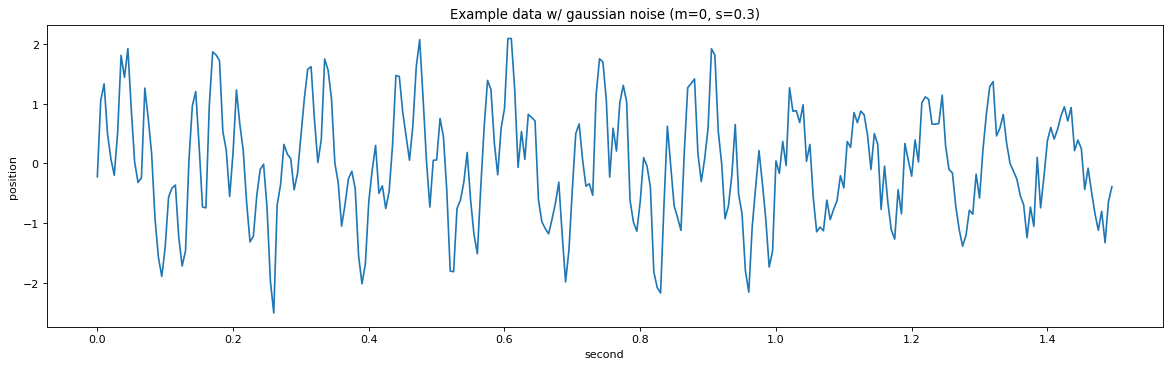

In [ ]:
fig=plt.figure(figsize=(18, 5), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(time[:300], X[:300])
plt.xlabel("second")
plt.ylabel("position")
plt.title("Example data w/ gaussian noise (m={}, s={})".format(mean, std))
plt.show()

<hr>
<strong>Created: </strong> July 30, 2020

<strong>Updated: </strong> August 31, 2020

<strong>Author: </strong> Dong Hur, Souvik Mandal, Jonah Brenner
<center><h1>Reference</h1></center>


* Dataset from Professor Venkatesh Murthy's Lab (Harvard University Department of Mollecular and Cellular Biology)